In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

In [3]:
def load_predictions(path, n=5, average=False):
    preds = []
    for i in range(n):
        preds.append(pd.read_csv(path.format(i), index_col=0))
    if average:
        # average over n
        preds = pd.concat(preds).groupby(level=0).mean()    
    else:
        # just append
        preds = pd.concat(preds)
    return preds

In [4]:
deep_preds = load_predictions("../results/networks/deep/pathological/eval/predictions_test_{}.csv")
deep_y_true = deep_preds["true_pathological"]
one_deep_y_true = load_predictions("../results/networks/deep/pathological/eval/predictions_test_{}.csv", average=True)["true_pathological"]
deep_preds = deep_preds["non-pathological"] <= deep_preds["pathological"]
assert len(deep_preds) == len(deep_y_true)

In [5]:
shallow_preds = load_predictions("../results/networks/shallow/pathological/eval/predictions_test_{}.csv")
shallow_y_true = shallow_preds["true_pathological"]
shallow_preds = shallow_preds["non-pathological"] <= shallow_preds["pathological"]
assert len(shallow_preds) == len(shallow_y_true)
assert len(shallow_preds) == len(deep_y_true)

In [6]:
tcn_preds = load_predictions("../results/networks/tcn/pathological/eval/predictions_test_{}.csv")
tcn_y_true = tcn_preds["true_pathological"]
tcn_preds = tcn_preds["non-pathological"] <= tcn_preds["pathological"]
assert len(tcn_preds) == len(tcn_y_true)
assert len(tcn_preds) == len(deep_y_true)

In [7]:
eegnet_preds = load_predictions("../results/networks/eegnet/pathological/eval/predictions_test_{}.csv")
eegnet_y_true = eegnet_preds["true_pathological"]
eegnet_preds = eegnet_preds["non-pathological"] <= eegnet_preds["pathological"]
assert len(eegnet_preds) == len(eegnet_y_true)
assert len(eegnet_preds) == len(deep_y_true)

In [8]:
rf_preds = pd.read_csv("../results/features/rf/pathological/without_age_and_gender/eval/predictions_eval.csv", index_col=0)#.groupby("group").mean()
rf_y_true = rf_preds["y_true"]
rf_preds = .5 <= rf_preds["y_pred"]
assert len(rf_preds) == len(rf_y_true)
assert len(rf_preds) == len(deep_y_true)

In [9]:
svm_preds = pd.read_csv("../results/features/svm/pathological/eval/predictions_eval.csv", index_col=0)#.groupby("group").mean()
svm_y_true = svm_preds["y_true"]
svm_preds = .5 <= svm_preds["y_pred"]
assert len(svm_preds) == len(svm_y_true)
assert len(svm_preds) == len(one_deep_y_true)

In [10]:
asc_preds = pd.read_csv("/home/gemeinl/results/all_recs_100_hz/features/asc/pathological/probas_eval.csv", index_col=0)
asc_preds = .5 <= asc_preds["1"]
assert len(asc_preds) == len(one_deep_y_true)

In [11]:
asc_preds = load_predictions("../results/features/asc/pathological/probas_eval_{}.csv")
asc_preds = .5 <= asc_preds["1"]
assert len(asc_preds) == len(deep_y_true)

In [12]:
riemanniam_preds = pd.read_csv("../results/features/riemannian/pathological/eval/predictions_eval.csv", index_col=0)
riemanniam_preds = .5 <= riemanniam_preds["y_pred"]
assert len(riemanniam_preds) == len(one_deep_y_true)

In [13]:
from collections import OrderedDict

In [14]:
preds_dict = OrderedDict({
    "BD-Deep4": deep_preds, 
    "BD-Shallow": shallow_preds, 
    "BD-TCN": tcn_preds, 
    "BD-EEGNet": eegnet_preds, 
    "RF": rf_preds, 
    "SVM": svm_preds,  
    "RG": riemanniam_preds,
    "ASC": asc_preds, 
})

In [15]:
# check that network and feature ground truths are the same
for ix, l in enumerate(deep_y_true):
    assert rf_y_true.values[ix] == l
y_true = deep_y_true

In [16]:
from sklearn.metrics import confusion_matrix

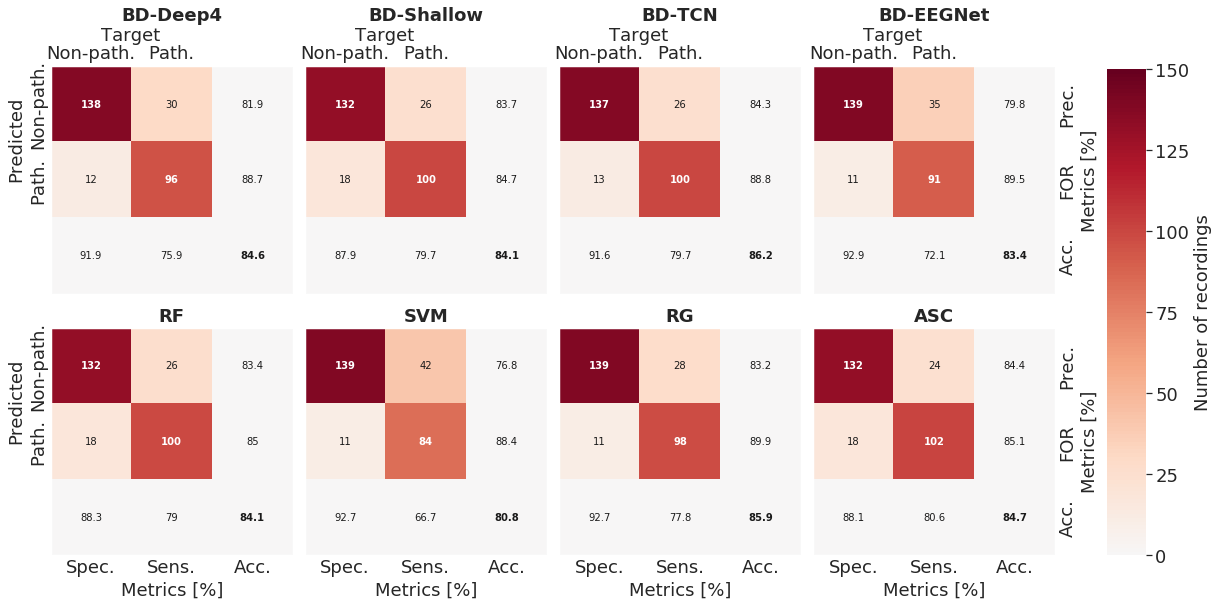

In [17]:
fs = 18
fig, ax_arr = plt.subplots(2,4, figsize=(18,9))
plt.subplots_adjust(wspace=.05, hspace=.15)
#plt.subplots_adjust(wspace=.55, hspace=.6)
#plt.subplots_adjust(wspace=.25, hspace=.6)

for i, (model, preds) in enumerate(preds_dict.items()):
    if model in ["RG", "SVM"]:
        accuracy = (one_deep_y_true.values == preds).mean() * 100
        cm = confusion_matrix(preds, one_deep_y_true)
        #cm =np.true_divide(cm, [150, 126]) * 100
    else:
        accuracy = (deep_y_true.values == preds).mean() * 100
        cm = confusion_matrix(preds, deep_y_true)
        cm = cm/5
        #cm =np.true_divide(cm, [150*5, 126*5]) * 100
    # add sensitivity/specificity, precision and accuracy
    specificity = cm[0,0]/(cm[0,0]+cm[0,1]) * 100
    sensitivity = cm[1,1]/(cm[1,1]+cm[1,0]) * 100
    
    precision1 = cm[0,0]/(cm[0,0]+cm[1,0]) * 100
    precision2 = cm[1,1]/(cm[0,1]+cm[1,1]) * 100
    cm2 = np.hstack((cm, [[precision1], [precision2]]))
    cm2 = np.vstack((cm2, [[specificity, sensitivity, accuracy]]))
    
    cm = np.hstack((cm, [[0], [0]]))
    cm = np.vstack((cm, [[0, 0, 0]]))
    
    cbar_ax = fig.add_axes([.94, .125, .03, .75]) if i == 0 else None
    vmax=150
    cbar = True if i == 0 else False
    ax = ax_arr[int(i/4)][i%4]
    ax = sns.heatmap(cm, center=0, cmap="RdBu_r", ax=ax, cbar=cbar, cbar_ax=cbar_ax, vmax=vmax)#, cbar_kws={"label": "Number of recordings"})
    if i == 0:
        ax.figure.axes[-1].set_ylabel("Number of recordings", size=fs)
        ax.figure.axes[-1].set_yticklabels([0, 25, 50, 75, 100, 125, 150], size=fs)
        
    ax.set_title(model, size=fs, weight="bold")
    ax.set_xticks([0.5,1.5,2.5])
    if int(i/4) == 1:
        ax.set_xticklabels(["Spec.", "Sens.", "Acc."], ha="center", size=fs)
        ax.set_xlabel("Metrics [%]", size=fs)
    else:
        ax.set_xticklabels([])
    ax.tick_params(length=0)
    if i % 4 == 0:
        ax.set_ylabel("Predicted", y=.68, size=fs)
        ax.set_yticklabels(["Non-path.", "Path."], va="center", size=fs)
    else:
        ax.set_yticklabels([])

    x_ax2 = ax.twiny()
    x_ax2.set_xlim(-.5,2.5)
    x_ax2.set_xticks([0, 1, 2])
    x_ax2.tick_params(length=0)
    x_ax2.grid(False)
    if int(i/4) == 0:
        x_ax2.set_xlabel("Target", x=.33, size=fs)
        x_ax2.set_xticklabels(["Non-path.", "Path."], ha="center", size=fs)
    else:
        x_ax2.set_xticklabels([])

    y_ax2 = ax.twinx()
    y_ax2.set_ylim(-.5,2.5)
    y_ax2.set_yticks([0, 1, 2])
    y_ax2.tick_params(length=0)
    y_ax2.grid(False)
    if i % 4 == 3:
        y_ax2.set_yticklabels(["Acc.", "FOR", "Prec."], rotation=90, va="center", size=fs)
        y_ax2.set_ylabel("Metrics [%]", size=fs)
    else:
        y_ax2.set_yticklabels([])

    for j in range(len(cm)-1):
        for k in range(len(cm[0])-1):
            text_c = "w" if cm[j, k] >= vmax/2 else "k"
            weight = None if j != k else "bold"
            ax.text(j+.5, k+.5, "{:.0f}".format(cm[k, j]), ha="center", va="center", color=text_c, weight=weight)

    text_c = "k"
    for j in range(len(cm2)):
        weight = None if j != len(cm2)-1 else "bold"
        ax.text(2.5, j+.5, "{:.3g}".format(cm2[2, j]), ha="center", va="center", color=text_c, weight=weight)
    # -1, dont plot accuracy twice
    for j in range(len(cm2[0])-1):
        ax.text(j+.5, 2.5, "{:.3g}".format(cm2[j, 2]), ha="center", va="center", color=text_c)